In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import pickle

## データ準備

### 訓練データ&検証データの読み込み

In [2]:
train_data = np.load("../1_data/train_data.npy")
train_label = np.load("../1_data/train_label.npy")

In [3]:
# 正規化
train_data = (train_data - train_data.min()) / train_data.max()
train_data = train_data.astype('float32')
# print(train_data)

In [4]:
# 配列形式変更
train_data = train_data.reshape(-1, 28*28)
print("train_data.shape=", train_data.shape)

train_data.shape= (3000, 784)


In [5]:
train, valid, y_train, y_valid = train_test_split(train_data, train_label, 
                                                    test_size=0.3, random_state=1234,
                                                    shuffle=True
                                                   )

print(train.shape, valid.shape)

(2100, 784) (900, 784)


In [6]:
# 配列形式変更
train = train.reshape(-1, 1, 28, 28)
valid = valid.reshape(-1, 1, 28, 28)

In [7]:
print(f'学習用データの形状：{train.shape}')
print(f'学習用ラベルの形状：{y_train.shape}')
print(f'検証用データの形状：{valid.shape}')
print(f'検証用ラベルの形状：{y_valid.shape}')

学習用データの形状：(2100, 1, 28, 28)
学習用ラベルの形状：(2100, 15)
検証用データの形状：(900, 1, 28, 28)
検証用ラベルの形状：(900, 15)


## モデル構築・学習

In [8]:
from common.deep_convnet import DeepConvNet
from common.trainer_onlineaugmented import Trainer


2022-10-08 10:57:39.034433: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-10-08 10:57:40.068905: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-10-08 10:57:40.068974: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-10-08 10:57:40.179043: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-10-08 10:57:42.319706: W tensorflow/stream_executor/platform/de

In [9]:
# sampled = 200 # 高速化のため
# train = train[:sampled]
# y_train = y_train[:sampled]

In [10]:
print("訓練データをセット")
print(f'trainのshape：{train.shape}')
print(f'y_trainのshape：{y_train.shape}')

訓練データをセット
trainのshape：(2100, 1, 28, 28)
y_trainのshape：(2100, 15)


In [11]:
# ネットワーク生成（モデル構築）
network = DeepConvNet()  
print("ネットワーク生成完了")


ネットワーク生成完了


In [12]:
aug_param = {
    'zoom_range': [0.7, 1.3],
    'rotation_range': 40,
    # 'vertical_flip': True,
    # 'horizontal_flip': True,
    'height_shift_range': 0.1,
    'width_shift_range': 0.1,
    'shear_range': 40,
    # 'channel_shift_range': 127
}
add_image_num = 420

In [ ]:
# 学習
trainer = Trainer(network, train, y_train, valid, y_valid,
                  aug_param, add_image_num, 
                  epochs=4, mini_batch_size=420, 
                  optimizer='RMSprop', optimizer_param={'lr':0.01, 'decay_rate':0.9},
                  evaluate_sample_num_per_epoch=1000)

# trainer = Trainer(network, train, y_train, valid, y_valid,
#                   epochs=20, mini_batch_size=100,
#                   optimizer='Adam', optimizer_param={'lr':0.001},
#                   evaluate_sample_num_per_epoch=1000)

trainer.train()

Trainerクラスのインスタンスが無事生成されました
optimizer:<common.optimizer.RMSprop object at 0x7fef1822cb20>
総iter数：20 = エポック数：4, ミニバッチ数：5.0
進捗：0.0%, 訓練データの誤差：14.5
==epoch:1, train_acc:0.06, test_acc:0.0756==
進捗：5.0%, 訓練データの誤差：2.71
進捗：10.0%, 訓練データの誤差：2.71
進捗：15.0%, 訓練データの誤差：2.72
進捗：20.0%, 訓練データの誤差：2.71
進捗：25.0%, 訓練データの誤差：2.71
==epoch:2, train_acc:0.076, test_acc:0.06==
進捗：30.0%, 訓練データの誤差：2.7
進捗：35.0%, 訓練データの誤差：2.7
進捗：40.0%, 訓練データの誤差：2.71
進捗：45.0%, 訓練データの誤差：2.71
進捗：50.0%, 訓練データの誤差：2.7
==epoch:3, train_acc:0.089, test_acc:0.0756==
進捗：55.0%, 訓練データの誤差：2.7
進捗：60.0%, 訓練データの誤差：2.7
進捗：65.0%, 訓練データの誤差：2.69
進捗：70.0%, 訓練データの誤差：2.7
進捗：75.0%, 訓練データの誤差：2.96
==epoch:4, train_acc:0.113, test_acc:0.0844==
進捗：80.0%, 訓練データの誤差：2.7


In [30]:
train_acc = trainer.train_acc_list
train_loss = trainer.train_loss_list
valid_acc = trainer.test_acc_list

In [31]:
print(len(train_acc))
print(len(train_loss))
print(len(valid_acc))

80
80
80


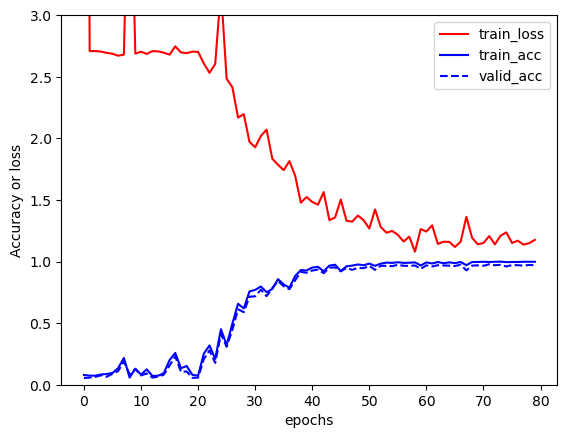

In [32]:
# lossとaccuracyのグラフ化
df_log = pd.DataFrame({"train_loss":train_loss,
             # "valid_loss":valid_loss,
             "train_acc":train_acc,
             "valid_acc":valid_acc})

df_log.plot(style=['r-', 'b-', 'b--'])
plt.ylim([0,3])
plt.ylabel("Accuracy or loss")
plt.xlabel("epochs")
plt.show()

### 学習済みモデルの出力

In [33]:
# with open("katakana_model.pickle", "wb") as f:
#     pickle.dump(tnet, f)

In [35]:
network.save_params("katakana_model.pickle")
print("Saved Network Parameters!")

Saved Network Parameters!
